# DeePC Implementation

### Packages

In [25]:
import osqp
import cvxpy as cp
import numpy as np

import scipy as sp
from scipy import sparse

import matplotlib.pyplot as plt
from scipy.linalg import hankel
%matplotlib inline

## Data Collection - Car 

## Trying with CartPole

In [26]:
import gym
import mujoco_py
from gym import wrappers
from IPython import display

env = gym.make('InvertedPendulum-v4', render_mode='rgb_array')
obs = env.reset()


ud = []
yd = []
done = False
for i in range(27):
    action = env.action_space.sample()
    obs, rew, done, info, _ = env.step(action)
    ud.append(action)
    yd.append(obs)

env.close()



In [27]:
T_ini = 4
n = 4
N = 5
env.close()
T = len(ud)
ud = np.array(ud)
yd = np.array(yd)

print(f'yd shape : {yd.shape}   ud shape : {ud.shape}')

L = T_ini + N + n
H = hankel(ud[0:L], ud[L:])
print(f'H has rank {np.linalg.matrix_rank(H)} and shape {H.shape}')

yd shape : (27, 4)   ud shape : (27, 1)
H has rank 13 and shape (13, 14)


In [28]:
L = T_ini + N
# Y_bad = hankel(yd[0:L,:], yd[L:,1])
# y_ = yd.reshape((108,1))

# (y_row,y_col) = yd.shape
yd = yd.reshape((27*4,))
U = hankel(ud[0:L], ud[L:])
Y = np.zeros((L*4, 27-L))
for i in range(0,T-L):
    Y[:,i] = yd[4*i:4*(L+i)]

Up = U[0:T_ini, :]
Uf = U[T_ini:, :]
print(f'U = {U.shape}, Up = {Up.shape}, Uf = {Uf.shape}')

Yp = Y[0:4*T_ini, :]
Yf = Y[4*T_ini:, :]
print(f'Y = {Y.shape}, Yp = {Yp.shape}, Yf = {Yf.shape}')

u_ini = ud[3:3+T_ini].reshape((T_ini,))
y_ini = yd[12:12+4*T_ini].reshape((4*T_ini,))


U = (9, 18), Up = (4, 18), Uf = (5, 18)
Y = (36, 18), Yp = (16, 18), Yf = (20, 18)


## Solver

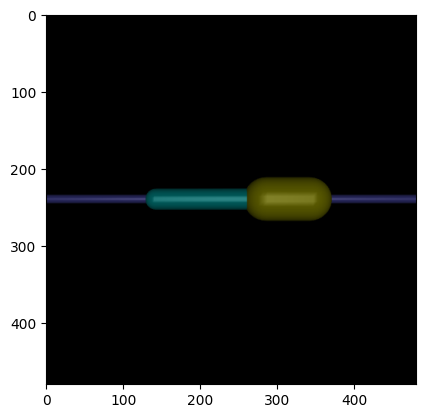

In [29]:
g = cp.Variable(T - T_ini - N)
u = cp.Variable(N)
y = cp.Variable(N*4)
sig_y = cp.Variable(4*T_ini)

Q = np.eye(N*4)
R = np.eye(N)*0.01
x_lower = np.ones(N)*0
x_upper = np.ones(N)*3


cost = cp.quad_form(y, Q) + cp.quad_form(u,R) + cp.norm1(g)*10 + cp.norm1(sig_y)*0.01

env = gym.make('InvertedPendulum-v4', render_mode='rgb_array')
obs = env.reset()
done = False
yT = [*y_ini]
uT = [*u_ini]
# print(yT)

for i in range(30):

  constraints = [
    Up @ g == u_ini,
    Yp @ g == y_ini + sig_y,
    Uf @ g == u,
    Yf @ g == y,
    # A@g == b,
    # cp.abs(u[::2]) <= accel_constraint,
    # cp.abs(u[1::2]) <= steer_constraint,
    # y <= x_upper,
    # y >= x_lower
  ]

  prob = cp.Problem(cp.Minimize(cost), constraints)
  prob.solve(solver=cp.OSQP, verbose=False)

  # for i in range(T_ini):
  plt.imshow(env.render())
  display.display(plt.gcf())    
  display.clear_output(wait=True)
  action = prob.variables()[1].value[0]
  # print(action)
  obs,_,_,_,_ = env.step([action])
  uT.append(action)
  for o in obs:
    yT.append(o) 
    
  # print(yT)
  u_ini = np.array(uT[-4:]).reshape(4,)
  y_ini = np.array(yT[-16:]).reshape(16,)





No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(136,)


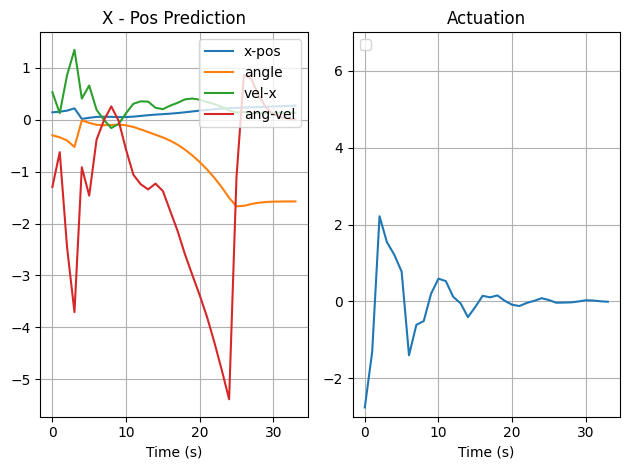

In [30]:
# time = np.array(list(range(0,N)))
# y = prob.variables()[0].value
# u = prob.variables()[1].value
yT = np.array(yT)
print(yT.shape)
yT = yT.reshape((34,4))
plt.subplot(1,2,1)
plt.plot(range(0,34), yT, label=['x-pos', 'angle', 'vel-x', 'ang-vel'])
plt.legend(loc="upper right")
plt.xlabel('Time (s)')
plt.title("X - Pos Prediction")
# plt.ylim((-3,7))
plt.grid('on')
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(range(0,34), uT)
plt.legend(loc="upper left")
plt.xlabel('Time (s)')
plt.title("Actuation")
plt.ylim((-3,7))
plt.grid('on')
plt.tight_layout()

plt.show()

In [31]:
A = np.array([
    [1,1,1,1],
    [2,2,2,2],
    [3,3,3,3],
    [4,4,4,4],
    [5,5,5,5],
    [6,6,6,6],
    [7,7,7,7],
])

# Get shape of A
(row,col) = A.shape
A = A.reshape((row*col,))

# Define L and T
L = 2
T = 7

# Fill in Hankel
H = np.zeros((L*col, T-L-1))
for i in range(0,T-L-1):
    H[:,i] = A[4*i:4*(L+i)]
H

array([[1., 2., 3., 4.],
       [1., 2., 3., 4.],
       [1., 2., 3., 4.],
       [1., 2., 3., 4.],
       [2., 3., 4., 5.],
       [2., 3., 4., 5.],
       [2., 3., 4., 5.],
       [2., 3., 4., 5.]])